# Data Preprocess for stacking the 2D CT images into 3D volumes (3DVAS)

Generate 3D NPY files

In [1]:
# Using the patchify package
!pip install patchify

In [2]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify

In [3]:
# Load the dataset
def load_2Dimages(folder):
    images = []
    # Keep the information of axis z (each slice)
    file_list = sorted(file for file in os.listdir(folder) if file.endswith('.png'))

    for filename in file_list:
        path = os.path.join(folder, filename)
        # Equalisation
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # grayscale
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))  
        img = clahe.apply(img)
        if img is not None:
            images.append(img)
    return images

# Stack them for 3D volume
def stack_3D_image(images):
    stacked_images = np.stack(images, axis=-1)
    return stacked_images

# Separate into patches
def patch_original(folder_path):
    images2D = load_2Dimages(folder_path)
    image = stack_3D_image(images2D)
    # step=128 for 16 patches means no overlap
    img_patches = patchify(image, (128, 128, 64), step=128)
    img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
    # 3 channels for the segmentation model (although grayscale just has 1 channel)
    original = np.stack((img,)*3, axis=-1)
    
    return original

def patch_mask(folder_path):
    images2D = load_2Dimages(folder_path)
    image = stack_3D_image(images2D)
    # step=128 for 16 patches means no overlap
    img_patches = patchify(image, (128, 128, 64), step=128)
    image3D = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
    
    # Two classes for 2 channels:  White (1, 0) Black (0, 1)
    mask_2_channels = np.zeros(image3D.shape + (2,))
    indices_greater_than_0_5 = np.where(image3D > 5)
    for idx in zip(*indices_greater_than_0_5):
        mask_2_channels[idx[0],idx[1],idx[2],idx[3],0] = 1

    indices_smaller_than_0_5 = np.where(image3D < 5)
    for idx in zip(*indices_smaller_than_0_5):
        mask_2_channels[idx[0],idx[1],idx[2],idx[3],1] = 1

    return mask_2_channels

In [13]:
# Paths
path_original1 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC1"
path_mask1 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC1"
path_original2 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC2"
path_mask2 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC2"
path_original3 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC3"
path_mask3 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC3"
path_original4 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC4"
path_mask4 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC4"
path_original5 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC5"
path_mask5 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC5"
path_original6 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC6"
path_mask6 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC6"
path_original7 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC7"
path_mask7 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC7"
path_original8 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC8"
path_mask8 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC8"
path_original9 = "/Users/yichunsun/Desktop/Data/3D/Training/Original/TAC9"
path_mask9 = "/Users/yichunsun/Desktop/Data/3D/Training/Mask/TAC9"

In [14]:
train_original1_3D = patch_original(path_original1)
train_mask1_3D = patch_mask(path_mask1)
train_original2_3D = patch_original(path_original2)
train_mask2_3D = patch_mask(path_mask2)
train_original3_3D = patch_original(path_original3)
train_mask3_3D = patch_mask(path_mask3)
train_original4_3D = patch_original(path_original4)
train_mask4_3D = patch_mask(path_mask4)
train_original5_3D = patch_original(path_original5)
train_mask5_3D = patch_mask(path_mask5)
train_original6_3D = patch_original(path_original6)
train_mask6_3D = patch_mask(path_mask6)
train_original7_3D = patch_original(path_original7)
train_mask7_3D = patch_mask(path_mask7)
train_original8_3D = patch_original(path_original8)
train_mask8_3D = patch_mask(path_mask8)
train_original9_3D = patch_original(path_original9)
train_mask9_3D = patch_mask(path_mask9)

In [44]:
# Change the order of the dataset for cross-validation
validation_original_3D = train_original9_3D
validation_mask_3D = train_mask9_3D

test_original_3D = train_original1_3D
test_mask_3D = train_mask1_3D

# For training: Stacking 3D volumes into a batch
train_original_3D = np.concatenate((train_original3_3D, train_original4_3D, train_original5_3D, train_original6_3D,
                             train_original7_3D, train_original8_3D, train_original2_3D), axis=0)
train_mask_3D = np.concatenate((train_mask3_3D, train_mask4_3D, train_mask5_3D,train_mask6_3D, 
                                train_mask7_3D, train_mask8_3D, train_mask2_3D), axis=0)

In [45]:
# Save the data
np.save('/Users/yichunsun/Desktop/Data/3D/3D_original_cv/3D_train_original9.npy', train_original_3D)
np.save('/Users/yichunsun/Desktop/Data/3D/3D_original_cv/3D_train_mask9.npy', train_mask_3D)
np.save('/Users/yichunsun/Desktop/Data/3D/3D_original_cv/3D_validation_original9.npy', validation_original_3D)
np.save('/Users/yichunsun/Desktop/Data/3D/3D_original_cv/3D_validation_mask9.npy', validation_mask_3D)
np.save('/Users/yichunsun/Desktop/Data/3D/3D_original_cv/3D_test_original9.npy', test_original_3D)
np.save('/Users/yichunsun/Desktop/Data/3D/3D_original_cv/3D_test_mask9.npy', test_mask_3D)

In [23]:
# Check the dimensions
print("Dimension of the training 3D original image:", train_original_3D.shape)
print("Dimension of the mask of training set:", train_mask_3D.shape)
print("Dimension of the validation 3D original image:", validation_original_3D.shape)
print("Dimension of the mask of validation set:", validation_mask_3D.shape)
print("Dimension of the test 3D original image:", test_original_3D.shape)
print("Dimension of the mask of test set:", test_mask_3D.shape)

Dimension of the training 3D original image: (112, 128, 128, 64, 3)
Dimension of the mask of training set: (112, 128, 128, 64, 2)
Dimension of the validation 3D original image: (16, 128, 128, 64, 3)
Dimension of the mask of validation set: (16, 128, 128, 64, 2)
Dimension of the test 3D original image: (16, 128, 128, 64, 3)
Dimension of the mask of test set: (16, 128, 128, 64, 2)


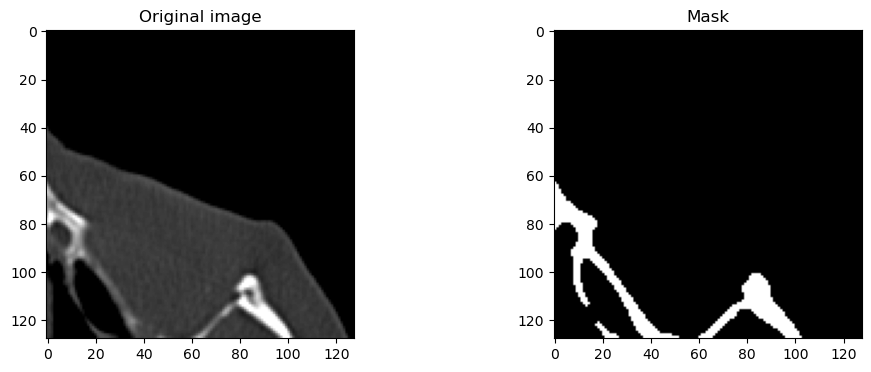

In [34]:
# Check the patches
# Change the patch and slice
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_3D[66,:,:,23,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_3D[66,:,:,23,0], cmap='gray')
axes[1].set_title('Mask')
    
plt.show()